<h1><b>Assignment 3</b></h1>
<ul>
    <li><u>Mauricio ...</u>: A00</li>
    <li><u>Carlos Flores Munguia</u>: A00831376</li>
<ul>

In this assignment we solve the CleanUp Puzzle formulating it as simple state problem to be solved by a problem-solving agent (PSA), then solving it by using selected uninformed search methods.

The first step is to initialize all the libraries which will be using during the execution of the algorithm.

In [1]:
!pip install ipythonblocks

from ipythonblocks import BlockGrid
from agents import *
from Objects import *

from search import ( # Bases for problem building
    Problem, Node, Graph, UndirectedGraph,
    SimpleProblemSolvingAgentProgram,
    GraphProblem
)

from search import ( # Uninformed search algorithms
    tree_search, graph_search, best_first_graph_search,
    breadth_first_tree_search, breadth_first_search,
    depth_first_tree_search, depth_first_graph_search,
    depth_limited_search, iterative_deepening_search,
    uniform_cost_search,
    compare_searchers
)

from search import ( # Informed search algorithms
    greedy_best_first_graph_search, astar_search
)

You should consider upgrading via the 'c:\users\carlo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


<h1>Environment:</h1>

This environment was declared to show the cleanup board's state in every step until solve the problem.

In [2]:
class CleanupPuzzleEnvironment(Environment):
    def __init__(self, width=5, height=5):
        super(CleanupPuzzleEnvironment, self).__init__()
        self.width = width
        self.height = height

        self.bg_color = (207, 216, 220)
        self.ball_color = (0, 191, 165)
        self.click_color = (244, 67, 54)
        self.grid = BlockGrid(width, height, fill=self.bg_color)

    def __str__(self):
        world = self.get_world()
        self.draw_grid(world)
        self.grid.show()
        return ''

    def draw_grid(self, world):
        self.grid[:] = self.bg_color
        for x in range(0, len(world)):
            for y in range(0, len(world[x])):
                if len(world[x][y]) and isinstance(world[x][y][0], Ball):
                    self.grid[x, y] = self.ball_color
                elif len(world[x][y]) and isinstance(world[x][y][0], Click):
                    self.grid[x, y] = self.click_color

    def get_world(self):
        '''returns the items in the world'''
        result = []
        for x in range(self.height):
            row = []
            for y in range(self.width):
                row.append(self.list_things_at((x, y)))
            result.append(row)
        return result

    def is_inbounds(self, location):
        '''Checks to make sure that the location is inbounds'''
        x,y = location
        return not (x < 0 or x >= self.height or y < 0 or y >= self.width)


# Problem

This class is called CleanBoardProblem which is derived from Problem where we initialize the initial and goal state and the size of the board.

Some of the methods that we need to define in order to solve a particular problems are:
<ul>
    <li>actions(): </li> According to the problem in every state, we need to get a list of actions that could be performed following the rules of the game.
    <li>result(): </li> It results the resulting new state after aplaying the action that is described in the parameters.
    <li>goal_test(): </li> Checks if the current state is equals to the goal state.
    <li>path_cost: </li> Adds cost to move from the actual state to the following state.
    
</ul>


In [3]:
class CleanBoardProblem(Problem):
    def __init__(self, initial=[], goal=[], size=5):
        Problem.__init__(self, initial, goal)
        self.size = size

    def actions(self, state):
        action_coords = []

        for (x, y) in state:
            near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]
            for loc in near_locations:
                if self.is_inbounds(loc) and loc not in state and loc not in action_coords:
                    action_coords.append(loc)

        sorted_list = sorted(action_coords, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def result(self, state, action):
        x, y = action
        near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]

        new_state = [e for e in state]
        for loc in near_locations:
            if self.is_inbounds(loc) and loc not in new_state:
                new_state.append(loc)
            elif self.is_inbounds(loc) and loc in new_state:
                new_state.remove(loc)

        sorted_list = sorted(new_state, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def goal_test(self, state):
        if len(state) < 1:
            return True
        return False

    def path_cost(self, c, state1, action, state2):
        diff = len(state2) - len(state1)
        return c + diff

    def is_inbounds(self, location):
        '''Checks to make sure that the location is inbounds'''
        x,y = location
        return not (x < 0 or x >= self.size or y < 0 or y >= self.size)


# Visualization Functions
The display_solution() function is declared to print the path followed by the search method until it solved the problem. At every step it shows the cell where there are balls and the cell where the click was made.

In [4]:
def display_solution(solution, initial_state, size):
    if not solution:
        print("Failure: no solution found")
        return

    print('Initial State:')
    environment = CleanupPuzzleEnvironment(size, size)
    for loc in initial_state:
        ball = Ball()
        environment.add_thing(ball, loc)
    print(environment)

    i = 0
    path = solution.path()
    for p in path:
        print('Step %s:' % (i+1))
        environment = CleanupPuzzleEnvironment(size, size)

        sol = solution.solution()
        if i < len(sol):
            click = Click()
            environment.add_thing(click, sol[i])

        for loc in p.state:
            ball = Ball()
            environment.add_thing(ball, loc)
        
        print(environment)
        print('')
        i += 1

# Tests
In this section we create a new Cleanup Puzzle problem in order to solve it using different search methods. In the following cells you can see the steps followed to reach a state where the board is clean of balls.

<u>Using Beadth First Search</u>

In [70]:
import time
# (ROW,COLUMN)
# initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4)])
# size = 5
initial_state = tuple([(0,2),(0,4),(1,0),(1,3),(1,5),(2,1),(2,4),(3,0),(3,2),(3,4),(4,3),(4,5),(5,0),(5,2),(5,4),])
size = 6

# initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]
# size = 11
initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

# problem = CleanBoardProblem(initial_state, [], size)
# problem.result(initial_state, (0,1))

problem = CleanBoardProblem(initial_state, [], size)
start_time_bfs = time.time()
goalBFS = breadth_first_search(problem)
end_time_bfs = time.time() - start_time_bfs
# goalDFS = depth_first_graph_search(problem)
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

display_solution(goalBFS, initial_state, size)

KeyboardInterrupt: 

<u>Using Depth First Search (with graph)</u>

In [21]:
start_time_dfs = time.time()
goalDFS = depth_first_graph_search(problem)
end_time_dfs = time.time() - start_time_dfs
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

display_solution(goalDFS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Uniform Cost Search</u>

In [22]:
start_time_ucs = time.time()
goalUCS = uniform_cost_search(problem)
end_time_ucs = time.time() - start_time_ucs
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

display_solution(goalUCS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Depth Limited Search</u>

In [23]:
start_time_dls = time.time()
goalDLS = depth_limited_search(problem)
end_time_dls = time.time() - start_time_dls
# goalIDS = iterative_deepening_search(problem)

# goal1 = uniform_cost_search(problem)

display_solution(goalDLS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 5:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 6:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 7:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 8:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 9:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 10:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 11:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 12:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 13:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 14:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 15:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 16:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 17:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 18:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 19:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 20:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 21:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 22:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 23:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 24:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 25:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 26:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 27:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 28:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 29:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 30:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 31:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 32:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 33:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 34:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 35:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 36:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 37:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 38:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 39:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 40:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 41:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 42:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 43:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 44:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 45:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 46:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 47:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 48:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 49:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 50:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 51:


,,,,
,,,,
,,,,
,,,,
,,,,


<u>Using Iterative Deepening Search</u>

In [24]:
start_time_ids = time.time()
goalIDS = iterative_deepening_search(problem)
end_time_ids = time.time() - start_time_ids

display_solution(goalIDS, initial_state, size)

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,


# Some Metrics


This bar graph represents the total time taken by each search method to solve the problem. The less time they took, the better.

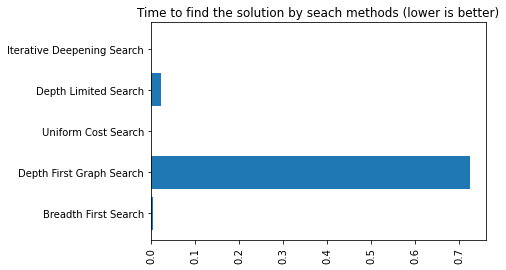

In [25]:
import matplotlib.pyplot as plt

searchMethods = ['Breadth First Search', 'Depth First Graph Search', 'Uniform Cost Search', 'Depth Limited Search', 'Iterative Deepening Search']
timeToExecute = [end_time_bfs,end_time_dfs,end_time_ucs,end_time_dls,end_time_ids]

plt.barh(searchMethods,timeToExecute)
plt.xticks(rotation=90)
plt.title('Time to find the solution by seach methods (lower is better)')
plt.show()

Now, we present the total number of clicks on the board made by each search method until solve the problem.

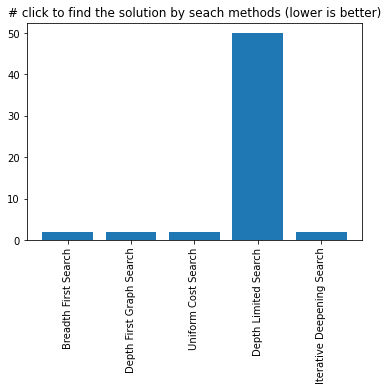

In [33]:
searchMethods = ['Breadth First Search', 'Depth First Graph Search', 'Uniform Cost Search', 'Depth Limited Search', 'Iterative Deepening Search']

goalBFS = breadth_first_search(problem)
# goalDFS = depth_first_graph_search(problem)
# goalUCS = uniform_cost_search(problem)
# goalDLS = depth_limited_search(problem)
# goalIDS = iterative_deepening_search(problem)

numberOfClicks = [
        len(goalBFS.solution()),
        len(goalDFS.solution()),
        len(goalUCS.solution()),
        len(goalDLS.solution()),
        len(goalIDS.solution())
    ]

plt.bar(searchMethods,numberOfClicks)
plt.xticks(rotation=90)
plt.title('# click to find the solution by seach methods (lower is better)')
plt.show()

In [ ]:
Finally, these graphs represents how the number of balls on the board was changing at every click.

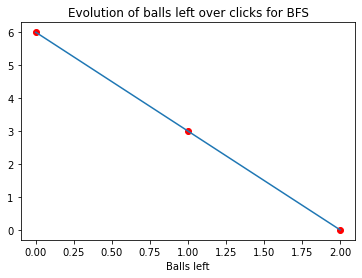

In [66]:
import numpy as np

# BFS
ballsLeftBFS = []
for i in range(len(goalBFS.solution())):
    ballsLeftBFS.append(len(goalBFS.path()[i].state))
ballsLeftBFS.append(0)

clicksBFS = np.arange(0,len(goalBFS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for BFS')
plt.plot(clicksBFS, ballsLeftBFS)
plt.scatter(clicksBFS, ballsLeftBFS, c='r')

# plt.xlabel('Click number')
# plt.xlabel('Balls left')
# plt.title('Evolution of balls left over clicks')
# plt.plot(clicks, ballsLeft)
# plt.scatter(clicks, ballsLeft, c='r')

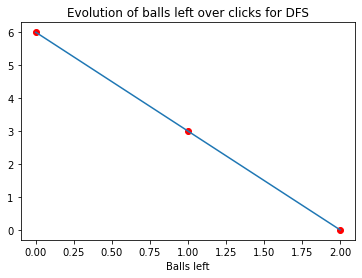

In [64]:
# DFS
ballsLeftDFS = []
for i in range(len(goalDFS.solution())):
    ballsLeftDFS.append(len(goalDFS.path()[i].state))
ballsLeftDFS.append(0)

clicksDFS = np.arange(0,len(goalDFS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for DFS')
plt.plot(clicksDFS, ballsLeftDFS)
plt.scatter(clicksDFS, ballsLeftDFS, c='r')

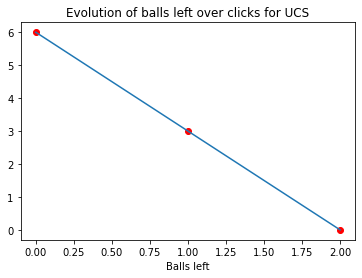

In [65]:
# UCS
ballsLeftUCS = []
for i in range(len(goalUCS.solution())):
    ballsLeftUCS.append(len(goalUCS.path()[i].state))
ballsLeftUCS.append(0)

clicksUCS = np.arange(0,len(goalUCS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for UCS')
plt.plot(clicksUCS, ballsLeftUCS)
plt.scatter(clicksUCS, ballsLeftUCS, c='r')

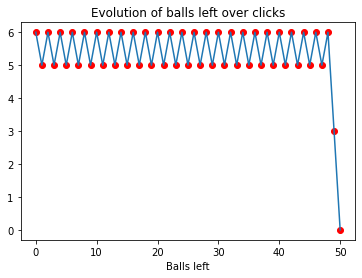

In [67]:
# DLS
ballsLeftDLS = []
for i in range(len(goalDLS.solution())):
    ballsLeftDLS.append(len(goalDLS.path()[i].state))
ballsLeftDLS.append(0)

clicksDLS = np.arange(0,len(goalDLS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for DLS')
plt.plot(clicksDLS, ballsLeftDLS)
plt.scatter(clicksDLS, ballsLeftDLS, c='r')

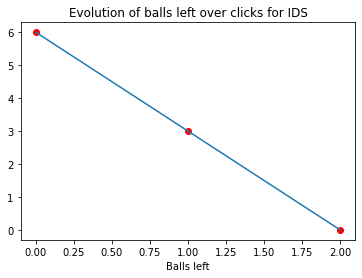

In [68]:
# DLS
ballsLeftIDS = []
for i in range(len(goalIDS.solution())):
    ballsLeftIDS.append(len(goalIDS.path()[i].state))
ballsLeftIDS.append(0)

clicksIDS = np.arange(0,len(goalIDS.path()), 1)

plt.xlabel('Click number')
plt.xlabel('Balls left')
plt.title('Evolution of balls left over clicks for IDS')
plt.plot(clicksIDS, ballsLeftIDS)
plt.scatter(clicksIDS, ballsLeftIDS, c='r')

# Conclusions:
<ul>
    <li><b>Could all the search methods solve the problem?</b></li> If you give them enough time and space, they can reach the goal state.
    <li><b>How efficient they were?</b></li> Some of them even looked that they would never reach the goal state, for example, BFS and DFS require much more time to execute big problems than Uniform Cost Search, and even Depth Limited Search could not have ended if it had not been for the limit of 50. But despite of the problems in time and space of Breath First Search and Uniform Cost Search, those method could find a solution in a few click on the board, while the Depth First Search has the worst time to find the solution and the worst number of clicks on the board until found the solution. Overall, DFS is the worst method in this kind of problem.
    <li><b>Was it difficult to program the Problem Solving Agent?</b></li> Nope, the only problem was to understand on how represent our states and try to capture that abstract idea inside the logic of the program.
    <li><b>Which search method overperforms the others?</b></li> 
</ul>

In [27]:
environment = CleanupPuzzleEnvironment(11, 11)

initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
